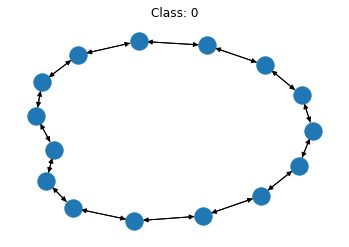

In [1]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# 数据集包含了80张图。每张图有10-20个节点
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [4]:
import dgl

def collate(samples):
    # 输入`samples` 是一个列表
    # 每个元素都是一个二元组 (图, 标签)
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [5]:
import dgl.function as fn
import torch
import torch.nn as nn

# 将节点表示h作为信息发出
msg = fn.copy_src(src='h', out='m')

In [6]:
def reduce(nodes):
    """对所有邻节点节点特征求平均并覆盖原本的节点特征。"""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

In [8]:
class NodeApplyModule(nn.Module):
    """将节点特征 hv 更新为 ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

In [10]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCNLayer, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # 使用 h 初始化节点特征。
        g.ndata['h'] = feature
        # 使用 update_all接口和自定义的消息传递及累和函数更新节点表示。
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [32]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float()
        # 应用图卷积和激活函数
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        with g.local_scope():
            g.ndata['h'] = h
            # 使用平均读出计算图表示
            hg = dgl.mean_nodes(g, 'h')
            return self.classify(hg)

In [36]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        # 两层图卷积层。
        self.layers = nn.ModuleList([
            GCNLayer(in_dim, hidden_dim, F.relu),
            GCNLayer(hidden_dim, hidden_dim, F.relu)])
        # 分类层。
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, h='none'):
        # 使用节点度数作为初始节点表示。
        h = g.in_degrees().view(-1, 1).float()
        # 图卷积层。
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        # 读出函数。
        graph_repr = dgl.mean_nodes(g, 'h')
        # 分类层。
        return self.classify(graph_repr)

In [24]:
import torch.optim as optim
from torch.utils.data import DataLoader

# 创建一个训练数据集和测试数据集
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# 使用 PyTorch 的 DataLoader 和之前定义的 collate 函数。
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

In [37]:
# 创建模型
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

Classifier(
  (layers): ModuleList(
    (0): GCNLayer(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1, out_features=256, bias=True)
      )
    )
    (1): GCNLayer(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
    )
  )
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [38]:
epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.1527
Epoch 1, loss 1.9239
Epoch 2, loss 1.7827
Epoch 3, loss 1.6993
Epoch 4, loss 1.6490
Epoch 5, loss 1.5170
Epoch 6, loss 1.4690
Epoch 7, loss 1.4262
Epoch 8, loss 1.3272
Epoch 9, loss 1.2695
Epoch 10, loss 1.2044
Epoch 11, loss 1.1734
Epoch 12, loss 1.0998
Epoch 13, loss 1.0613
Epoch 14, loss 1.0107
Epoch 15, loss 0.9930
Epoch 16, loss 0.9676
Epoch 17, loss 0.9376
Epoch 18, loss 0.9026
Epoch 19, loss 0.8827
Epoch 20, loss 0.8618
Epoch 21, loss 0.8443
Epoch 22, loss 0.8249
Epoch 23, loss 0.7959
Epoch 24, loss 0.7890
Epoch 25, loss 0.7667
Epoch 26, loss 0.7610
Epoch 27, loss 0.7790
Epoch 28, loss 0.7335
Epoch 29, loss 0.7247
Epoch 30, loss 0.7065
Epoch 31, loss 0.6948
Epoch 32, loss 0.6852
Epoch 33, loss 0.6615
Epoch 34, loss 0.6579
Epoch 35, loss 0.6845
Epoch 36, loss 0.6486
Epoch 37, loss 0.6527
Epoch 38, loss 0.6387
Epoch 39, loss 0.6016
Epoch 40, loss 0.5863
Epoch 41, loss 0.5882
Epoch 42, loss 0.5876
Epoch 43, loss 0.6042
Epoch 44, loss 0.5779
Epoch 45, loss 0.555

In [42]:
bg.batch_size

32

In [40]:
model(bg).shape

torch.Size([32, 8])

In [43]:
graphs, labels = zip(*[trainset[i] for i in range(16)])
batched_graphs = dgl.batch(graphs)
batched_labels = torch.tensor(labels)
batched_graphs, batched_labels

(Graph(num_nodes=237, num_edges=711,
       ndata_schemes={}
       edata_schemes={}),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [46]:
batched_graphs.batch_num_nodes()

tensor([15, 10, 13, 13, 17, 19, 13, 15, 12, 14, 17, 16, 18, 18, 11, 16])

In [47]:
torch.tensor([1,2,3])

tensor([1, 2, 3])